<a href="https://colab.research.google.com/github/mekhanikaladvantage/vneural-pdes/blob/main/DeepRitz_Jax_10D_poisson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Poisson problem in 10D
NOTE: This code is not very user-friendly, but it does work I promise

In [ ]:
'''
Imports
'''
!pip install optax #must be run at the start of the session.

from jax import jit, grad, vmap, value_and_grad
from jax import random, nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
import math

# # JAX_DEBUG_NANS=True
# JAX_DEBUG_NANS = False
# from jax.config import config
# # config.update("jax_debug_nans",True)
# config.update("jax_debug_nans",False)
# config.parse_flags_with_absl()

#set 64 bit precision
# JAX_ENABLE_X64=True
# JAX_ENABLE_X64=False

%xmode context
# %xmode verbose

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Exception reporting mode: Context


Hyperparameters
==========

In [ ]:
#set hyperparameters

# this creates random parameters for the weights and biases of a given node
def random_layer_params(m:int,n:int,key, scale = 2e-1) -> tuple:
    '''
    currenly using the normalized Bengio-Glorot initialization.
    '''
    w_key, b_key = random.split(key)
    # return scale * random.normal(w_key,(n,m)), scale * random.normal(b_key,(n,1))
    minval = -6/(jnp.sqrt(m + n)) 
    # minval = 1
    maxval = -1*minval
    # maxval = 2
    w = scale * random.uniform(w_key,(n,m),minval = minval,maxval = maxval) #n x m
    b = scale * random.uniform(b_key,(n,),minval = minval,maxval = maxval) # vector of length n, 1 dimensional.
    return w,b 

# this should initalize nodes
def init_network_params(sizes:list,key) -> list:
    keys = random.split(key, len(sizes))
    return [random_layer_params(m,n,k) for m,n,k in zip(sizes[:-1],sizes[1:],keys)]


hypers = dict()
hypers["d"] = 10 #specified in exp
# hypers["m"] = 10 # specified in exp
hypers["m"] = 50 # for ff model
hypers["step size"] = 1e-03
hypers["num epochs"] = 50000 # specified in experiment
hypers["batch size"] = 1000 #specified in experiement
hypers["boundary size"] = 100 #specified in experiment
hypers["beta"] = 10**3 # specfified in experiment

#3 blocks, experiment replication for rn model
# layer_sizes = [hypers["d"],hypers["m"],hypers["m"],hypers["m"],hypers["m"],hypers["m"],hypers["m"],1]
layer_sizes = [hypers["d"],hypers["m"],hypers["m"],1] #1 hidden layer
# layer_sizes = [hypers["d"],hypers["m"],hypers["m"],hypers["m"],1] # 2 hidden layers
# layer_sizes = [hypers["d"],hypers["m"],hypers["m"],hypers["m"],hypers["m"],1] # 3 hidden layers

params = init_network_params(layer_sizes,random.PRNGKey(0))


optimizer = optax.adam(learning_rate = hypers["step size"])



Model
=====

In [ ]:
from jaxlib.xla_extension import DeviceArray
compiled_celu = jit(nn.celu)
compiled_softplus = jit(nn.softplus)


def relu(x) -> np.float32:
  return jnp.maximum(0,x**3) #propogates NaNs

def rn_model(params:list,x:DeviceArray) -> np.float32:
    '''
    params: list of weight, bias tuples. 
    x: Input vector. Should be shape (10,)
    '''
    w,b = params[0]
    output = jnp.dot(w,x) + b
    activations = relu(output)
    residual = activations #will be used for skip connection, needs right dim
    #evenness counter
    layer_number = 1
    i = 0
    
    for w,b in params[1:-1]: #first and last params are for linear transformation
        output = jnp.dot(w,activations) + b
        
        activations = relu(output)
        if i%2 == 0: #only have skip connection on even blocks
            activations += residual #add skip connection
            residual = activations #update residual
        layer_number += 1
        i += 1

        
    final_w,final_b = params[-1] 
    logits = jnp.dot(final_w,activations) + final_b
    return logits[0]


    #######

def ff_model(params:list,x:DeviceArray) -> np.float32:

    '''
    params: list of weight, bias tuples. 
    x: Input vector. Should be shape (10,)
    '''

    w,b = params[0]
    # print(w.shape)
    output = jnp.dot(w,x) + b
    activations = relu(output)
    #relu propogates nans
    
    for w,b in params[1:-1]: #first and last params are for linear transformation
        output = jnp.dot(w,activations) + b
        activations = relu(output)
        
    final_w,final_b = params[-1] 
    logits = jnp.dot(final_w,activations) + final_b
    return logits[0]

model = ff_model
# model = rn_model
batched_model = vmap(model,in_axes=(None,0)) 

In [ ]:
# model debugging
x = jnp.ones(shape=(10,))
# print(x.shape)
out = model(params,x) # 0.004663214
print(out)

-0.05899765


Batching
========
The domain is $(0,1)^{10}$, and the boundary is thus $\partial(0,1)^{10}$. I need to figure out how to sample from all of the hyperplanes, and there are a lot. 

In [ ]:
'''
Batching
'''
key, subkey = random.split(random.PRNGKey(0))
#  #need static argums batch dim size

nudge = jnp.finfo(np.float32).tiny
# print(nudge)


def get_batch(batch_size:int,key:DeviceArray) -> DeviceArray:
  return random.uniform(key,shape = (batch_size,hypers["d"]),minval=jnp.nextafter(0,jnp.inf),maxval=1)
  # nextafter necessary since uniform samples [minval,maxval). We want (minval,maxval).



ones = jnp.ones(shape=(hypers["boundary size"],))
zeros = jnp.zeros(shape=(hypers["boundary size"],))


def get_boundary_batch(bdy_batch_size:int,key:DeviceArray) -> DeviceArray:
  keys = random.split(key,num=3)
  # we have two extra keys bc we need them for sampling
  samples = [] 
  bdy_planes = [] #will keep every boundary section in a list
  # and then concatenate everything together
  high_end = jnp.nextafter(1,jnp.inf)

  for i in range(hypers["d"]):
    sample_1 = random.uniform(keys[0],shape=(bdy_batch_size,hypers["d"]-1),minval=0,maxval=high_end) #batch_size x 9
    bdy_with_ones = jnp.column_stack((sample_1[:,:i],ones,sample_1[:,i:]))
    bdy_planes.append(bdy_with_ones)
    # print(bdy_planes)

    sample_0 = random.uniform(keys[1],shape=(bdy_batch_size,hypers["d"] - 1),minval=0,maxval=high_end)
    bdy_with_zeros = jnp.column_stack((sample_0[:,:i],zeros,sample_0[:,i:]))
    bdy_planes.append(bdy_with_zeros)

    keys = random.split(keys[-1],num=3)
  #end

  return jnp.concatenate(bdy_planes[:],axis=0)



# ones = jnp.ones(shape=(4,))
# zeros = jnp.zeros(shape=(4),)
boundary = get_boundary_batch(hypers["boundary size"],subkey)
# interior = get_batch(4,subkey)
# print(interior)
print(boundary[395:405])
print(f'shape of boundary is {boundary.shape}')

[[0.6195981  0.         0.9493358  0.98605573 0.5314922  0.29239872
  0.21693209 0.28678992 0.33323732 0.69346875]
 [0.45833617 0.         0.3753485  0.05552114 0.04749466 0.3253658
  0.63035077 0.05912126 0.14282085 0.4722728 ]
 [0.5740563  0.         0.48856694 0.06821597 0.69677323 0.54419845
  0.7534684  0.4652515  0.30324903 0.9340564 ]
 [0.51124936 0.         0.5884581  0.3956265  0.62786025 0.9549519
  0.26241663 0.1764356  0.24474779 0.42905778]
 [0.658999   0.         0.46132344 0.07902563 0.96315765 0.5771019
  0.5376589  0.92542124 0.72533935 0.68740803]
 [0.12399687 0.13051058 1.         0.75323176 0.07509065 0.2454001
  0.66975695 0.63119036 0.30933312 0.34187868]
 [0.79504955 0.19154671 1.         0.8674109  0.65517706 0.01946259
  0.8920357  0.6438059  0.5649019  0.784969  ]
 [0.6629854  0.03233719 1.         0.0219177  0.16532232 0.6512037
  0.4348119  0.649674   0.6560424  0.06161106]
 [0.10647263 0.00745583 1.         0.93875897 0.2794092  0.6088727
  0.9891827  0.296

In [ ]:
'''
testing block - batching
'''
x = jnp.ones(shape=(10,10))
y = jnp.zeros(shape=(10,))
z = [x, y]
# delta = jnp.concatenate(z[:],axis=0)
stacks = []
print()
for i in range(len(x[0]) + 1):
  stack = jnp.column_stack((x[:,:i],y,x[:,i:]))
  stacks.append(stack)

output = jnp.concatenate(stacks[:],axis=0)
print(output[50:60,:])


[[1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]]


Loss and Update
=====

In [ ]:
'''
loss and update block
'''

from optax._src.base import OptState
from chex._src.pytypes import Device
from jax._src.random import KeyArray

def exact(x:DeviceArray) -> np.float32:
  #this function doubles as the boundary condition and also the exact solution to the problem. 
  output = 0
  for i in range(int(len(x)/2)):
    output += x[2*i]*x[2*i+1]
  return output



exact_vector = vmap(exact,in_axes=0)

def flow_loss_fn(params:list,x:DeviceArray) -> np.float32:
  '''
  flow loss calculated on 1 2D sample in order to have scalar output.
  The scalar output of the model necessary for autograd to work.
  '''
  dudx = grad(model,argnums=1)(params,x) # compute gradient wrt sample
  return 0.5*(jnp.sum(dudx*dudx)) #since f = 0

flow_loss_vector = vmap(flow_loss_fn,in_axes=(None,0)) 

def laplacian(params:list,x:DeviceArray) -> np.float32:
  return jnp.sum(grad(model,argnums=1)(params,x))

laplacian_vector = vmap(laplacian,in_axes=(None,0))
  
def pinn_loss(params,batch:DeviceArray) -> np.float32:
  return jnp.linalg.norm(laplacian_vector(params,batch))



def loss_fn(params:list,key:KeyArray) -> np.float32:
  '''
  this function samples data and calculates the loss.
  Please note that this function MUST be differentiable.
  The loss consists of two parts, an flow loss given by the energy,
  and a boundary loss to enforce boundary conditions. 
  '''
  # generate data
  keys = random.split(key,num=2)
  interior_sample = get_batch(hypers["batch size"],keys[0])
  boundary_sample = get_boundary_batch(hypers["boundary size"],keys[1])
  
  #calculate flow loss if using Deep Ritz loss
  flow_output = flow_loss_vector(params,interior_sample)
  flow_loss = jnp.mean(flow_output) 

  # PINN loss, if using
  # flow_loss = pinn_loss(params,interior_sample)


  #calculate boundary loss
  bdy_output = batched_model(params,boundary_sample)
  exact_output = exact_vector(boundary_sample)
  bdy_diff = exact_output - bdy_output
  bdy_loss = hypers["beta"]*jnp.mean(bdy_diff*bdy_diff)

  return jnp.add(flow_loss,bdy_loss)

def update(params:list,opt_state:OptState,key:KeyArray):
# def update(params:list,opt_state:OptState,interior_sample,boundary_sample):
  '''
  This calculates the parameter updates using the ADAM algorithm,
  as implemented in optax.
  '''

  loss,grads = value_and_grad(loss_fn,argnums=0)(params,key)

  updates,opt_state = optimizer.update(grads,opt_state,params)
  params = optax.apply_updates(params,updates)

  return params,opt_state,loss

#jit update for moar speed
compiled_update = jit(update)

In [ ]:
'''
debugging block - loss and update
'''
x = 2*jnp.ones(shape=(10,10))
y = loss_fn(params,random.PRNGKey(2))
print(y) # should be 5 

1956.1226


Training Loop
===========

In [ ]:
#reset key
key, train_key = random.split(random.PRNGKey(5))
params = init_network_params(layer_sizes,train_key)

# %xmode context
%xmode verbose


Exception reporting mode: Verbose


---------------
Epoch 0 in 2.61 additional seconds
Interior relative error is 0.9035120606422424
Boundary relative error is 0.9075668454170227
Total loss is 1529.5888671875
---------------
Epoch 1000 in 1.22 additional seconds
Interior relative error is 0.040786415338516235
Boundary relative error is 0.036792151629924774
Total loss is 4.327515602111816
---------------
Epoch 2000 in 1.25 additional seconds
Interior relative error is 0.014946410432457924
Boundary relative error is 0.015941647812724113
Total loss is 2.0940964221954346
---------------
Epoch 3000 in 1.21 additional seconds
Interior relative error is 0.013455729931592941
Boundary relative error is 0.013713110238313675
Total loss is 1.9656935930252075
---------------
Epoch 4000 in 1.22 additional seconds
Interior relative error is 0.009137564338743687
Boundary relative error is 0.009720278903841972
Total loss is 1.8369557857513428
---------------
Epoch 5000 in 1.52 additional seconds
Interior relative error is 0.0089105069637

<Figure size 640x480 with 0 Axes>

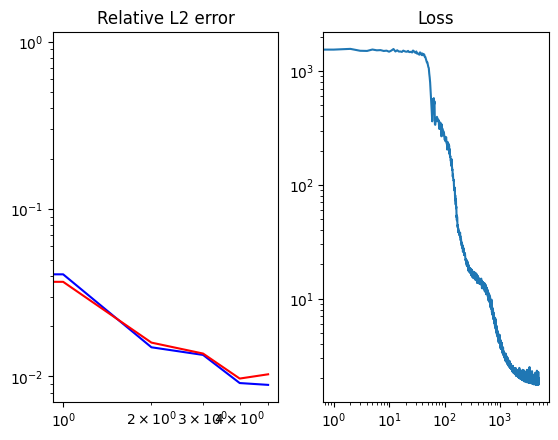

---------------
Epoch 6000 in 2.90 additional seconds
Interior relative error is 0.008849713020026684
Boundary relative error is 0.00927736796438694
Total loss is 1.7671324014663696
---------------
Epoch 7000 in 1.21 additional seconds
Interior relative error is 0.007830305956304073
Boundary relative error is 0.007286274805665016
Total loss is 1.7344447374343872
---------------
Epoch 8000 in 1.19 additional seconds
Interior relative error is 0.00932974275201559
Boundary relative error is 0.010808014310896397
Total loss is 1.8809902667999268
---------------
Epoch 9000 in 1.21 additional seconds
Interior relative error is 0.01065909769386053
Boundary relative error is 0.00994965247809887
Total loss is 1.9087032079696655
---------------
Epoch 10000 in 1.20 additional seconds
Interior relative error is 0.006817682646214962
Boundary relative error is 0.0073927841149270535
Total loss is 1.758091926574707


<Figure size 640x480 with 0 Axes>

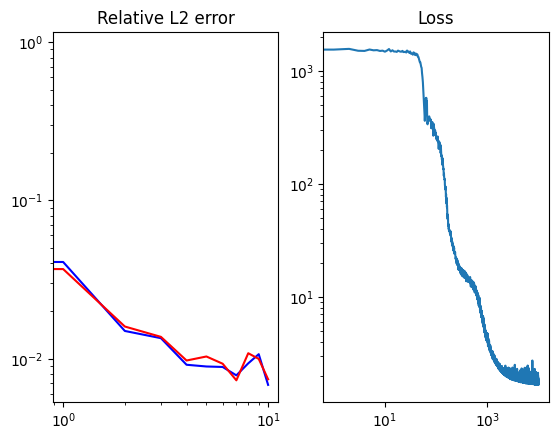

---------------
Epoch 11000 in 3.01 additional seconds
Interior relative error is 0.009922308847308159
Boundary relative error is 0.009112562984228134
Total loss is 1.7934255599975586
---------------
Epoch 12000 in 1.44 additional seconds
Interior relative error is 0.004762160126119852
Boundary relative error is 0.0051822783425450325
Total loss is 1.6923632621765137
---------------
Epoch 13000 in 1.20 additional seconds
Interior relative error is 0.00462306896224618
Boundary relative error is 0.004764726385474205
Total loss is 1.7137004137039185
---------------
Epoch 14000 in 1.18 additional seconds
Interior relative error is 0.010597825050354004
Boundary relative error is 0.01154390163719654
Total loss is 1.963883399963379
---------------
Epoch 15000 in 1.19 additional seconds
Interior relative error is 0.004678737372159958
Boundary relative error is 0.005283701699227095
Total loss is 1.7931193113327026


<Figure size 640x480 with 0 Axes>

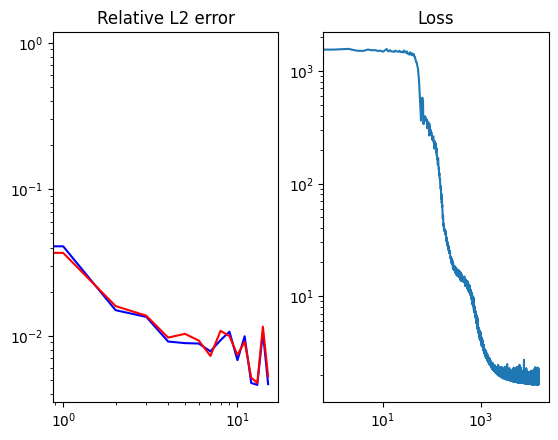

---------------
Epoch 16000 in 2.61 additional seconds
Interior relative error is 0.009766126051545143
Boundary relative error is 0.00932445377111435
Total loss is 1.7948170900344849
---------------
Epoch 17000 in 1.21 additional seconds
Interior relative error is 0.004921911284327507
Boundary relative error is 0.005545365624129772
Total loss is 1.7228271961212158
---------------
Epoch 18000 in 1.33 additional seconds
Interior relative error is 0.005284361075609922
Boundary relative error is 0.005095028784126043
Total loss is 1.703871726989746
---------------
Epoch 19000 in 1.56 additional seconds
Interior relative error is 0.004476991482079029
Boundary relative error is 0.005000845063477755
Total loss is 1.6663239002227783
---------------
Epoch 20000 in 1.21 additional seconds
Interior relative error is 0.003563466016203165
Boundary relative error is 0.0038851082790642977
Total loss is 1.6907724142074585


<Figure size 640x480 with 0 Axes>

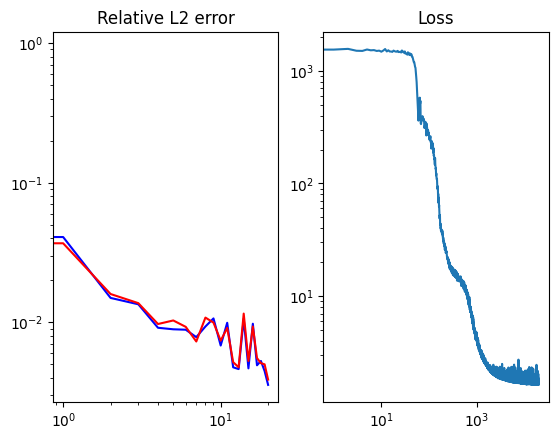

---------------
Epoch 21000 in 2.70 additional seconds
Interior relative error is 0.0034506982192397118
Boundary relative error is 0.0035889814607799053
Total loss is 1.680809736251831
---------------
Epoch 22000 in 1.16 additional seconds
Interior relative error is 0.005111403297632933
Boundary relative error is 0.005713095422834158
Total loss is 1.7195796966552734
---------------
Epoch 23000 in 1.18 additional seconds
Interior relative error is 0.005144611466675997
Boundary relative error is 0.005133968312293291
Total loss is 1.6812171936035156
---------------
Epoch 24000 in 1.14 additional seconds
Interior relative error is 0.004579505417495966
Boundary relative error is 0.0049696676433086395
Total loss is 1.6816362142562866
---------------
Epoch 25000 in 1.21 additional seconds
Interior relative error is 0.003257319563999772
Boundary relative error is 0.0033641469199210405
Total loss is 1.6728533506393433


<Figure size 640x480 with 0 Axes>

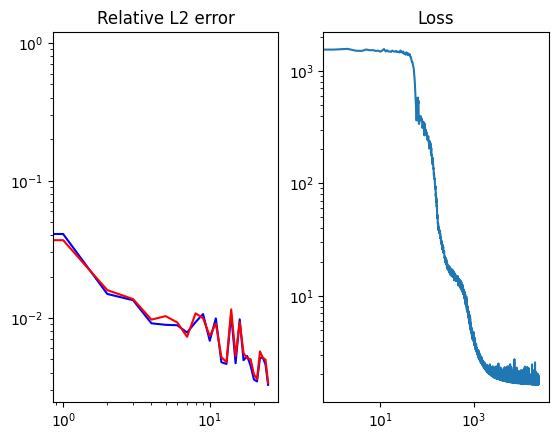

---------------
Epoch 26000 in 3.64 additional seconds
Interior relative error is 0.004111395683139563
Boundary relative error is 0.004656442441046238
Total loss is 1.6936779022216797
---------------
Epoch 27000 in 1.17 additional seconds
Interior relative error is 0.0033449793700128794
Boundary relative error is 0.003654471831396222
Total loss is 1.6938605308532715
---------------
Epoch 28000 in 1.96 additional seconds
Interior relative error is 0.004914579913020134
Boundary relative error is 0.004894197918474674
Total loss is 1.6993122100830078
---------------
Epoch 29000 in 1.23 additional seconds
Interior relative error is 0.007851332426071167
Boundary relative error is 0.007673739921301603
Total loss is 1.733869194984436
---------------
Epoch 30000 in 1.23 additional seconds
Interior relative error is 0.005514228250831366
Boundary relative error is 0.005652785301208496
Total loss is 1.7050106525421143


<Figure size 640x480 with 0 Axes>

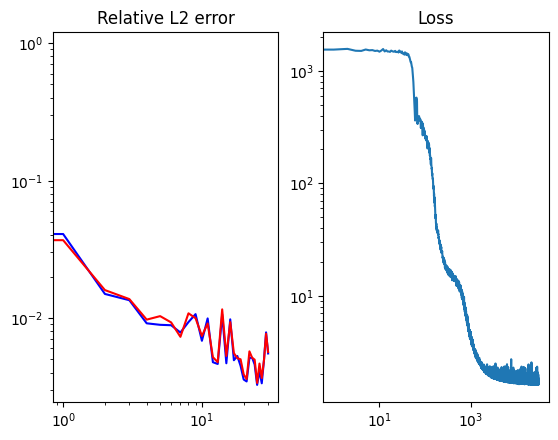

---------------
Epoch 31000 in 2.85 additional seconds
Interior relative error is 0.005452159326523542
Boundary relative error is 0.005329457577317953
Total loss is 1.7014645338058472
---------------
Epoch 32000 in 1.52 additional seconds
Interior relative error is 0.006515796296298504
Boundary relative error is 0.007315735332667828
Total loss is 1.7196736335754395
---------------
Epoch 33000 in 1.19 additional seconds
Interior relative error is 0.0077371615916490555
Boundary relative error is 0.007659161929041147
Total loss is 1.7092291116714478
---------------
Epoch 34000 in 1.18 additional seconds
Interior relative error is 0.0056471810676157475
Boundary relative error is 0.005567875225096941
Total loss is 1.695024013519287
---------------
Epoch 35000 in 1.30 additional seconds
Interior relative error is 0.006501193158328533
Boundary relative error is 0.0065475585870444775
Total loss is 1.686284065246582


<Figure size 640x480 with 0 Axes>

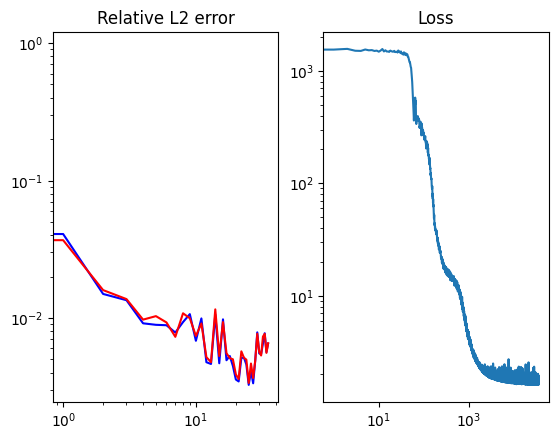

---------------
Epoch 36000 in 3.60 additional seconds
Interior relative error is 0.005613680928945541
Boundary relative error is 0.005571844521909952
Total loss is 1.6859605312347412
---------------
Epoch 37000 in 1.19 additional seconds
Interior relative error is 0.0039347386918962
Boundary relative error is 0.004610085394233465
Total loss is 1.704922080039978
---------------
Epoch 38000 in 1.50 additional seconds
Interior relative error is 0.007265703286975622
Boundary relative error is 0.007035066373646259
Total loss is 1.6977968215942383
---------------
Epoch 39000 in 1.39 additional seconds
Interior relative error is 0.003996490966528654
Boundary relative error is 0.004174906760454178
Total loss is 1.6596169471740723
---------------
Epoch 40000 in 1.20 additional seconds
Interior relative error is 0.0031052089761942625
Boundary relative error is 0.003301742486655712
Total loss is 1.6638712882995605


<Figure size 640x480 with 0 Axes>

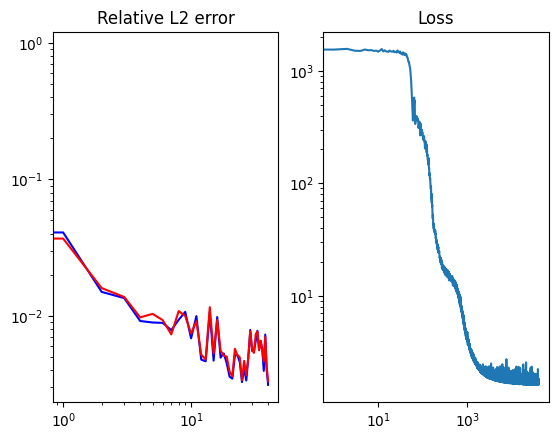

---------------
Epoch 41000 in 2.85 additional seconds
Interior relative error is 0.004536919761449099
Boundary relative error is 0.004638047888875008
Total loss is 1.674045205116272
---------------
Epoch 42000 in 1.16 additional seconds
Interior relative error is 0.004290846176445484
Boundary relative error is 0.0043204245157539845
Total loss is 1.6589494943618774
---------------
Epoch 43000 in 1.18 additional seconds
Interior relative error is 0.0037833540700376034
Boundary relative error is 0.004010171629488468
Total loss is 1.674619197845459
---------------
Epoch 44000 in 1.21 additional seconds
Interior relative error is 0.0097986264154315
Boundary relative error is 0.00977935828268528
Total loss is 1.75672447681427
---------------
Epoch 45000 in 1.36 additional seconds
Interior relative error is 0.003088763216510415
Boundary relative error is 0.003582923673093319
Total loss is 1.6879514455795288


<Figure size 640x480 with 0 Axes>

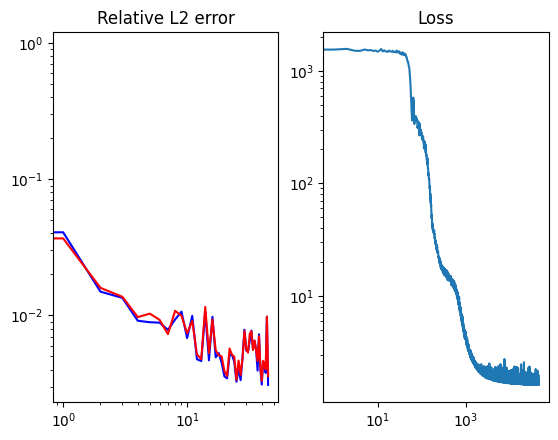

---------------
Epoch 46000 in 3.23 additional seconds
Interior relative error is 0.0026239294093102217
Boundary relative error is 0.003166383132338524
Total loss is 1.6660596132278442
---------------
Epoch 47000 in 1.18 additional seconds
Interior relative error is 0.005739135667681694
Boundary relative error is 0.0056139943189918995
Total loss is 1.6449865102767944
---------------
Epoch 48000 in 1.18 additional seconds
Interior relative error is 0.003909587860107422
Boundary relative error is 0.004081733990460634
Total loss is 1.6853841543197632
---------------
Epoch 49000 in 1.18 additional seconds
Interior relative error is 0.004491582978516817
Boundary relative error is 0.004753082524985075
Total loss is 1.6778417825698853
Epoch 49999 in 1.18 sec
Final loss is  1.6793650388717651


In [ ]:
#training loop
import time

flow_losses = []
bdy_losses = []
training_losses = []
flow_residuals = []
bdy_residuals = []


opt_state = optimizer.init(params)
start_time = time.time()

for epoch in range(hypers["num epochs"]):
    
    key,train_key = random.split(key)
    
    
    params,opt_state,train_loss = compiled_update(params,opt_state,train_key)

    training_losses.append(train_loss)
    
    if epoch%1000 == 0:
      

      epoch_time = time.time() - start_time

      keys = random.split(train_key,num=2)
      int_out_batch = get_batch(hypers["batch size"],keys[0])
      bdy_out_batch = get_boundary_batch(hypers["boundary size"],keys[1])

      flow_output = flow_loss_vector(params,int_out_batch) #these two are for dr loss
      flow_train_loss = jnp.mean(flow_output)

      # flow_train_loss = pinn_loss(params,int_out_batch) # for pinn loss
      
      flow_losses.append(flow_train_loss)

      bdy_output = batched_model(params,bdy_out_batch)
      exact_bdy = exact_vector(bdy_out_batch)
      bdy_diff = bdy_output - exact_bdy
      bdy_train_loss = hypers["beta"]*jnp.mean(bdy_diff*bdy_diff)
      bdy_losses.append(bdy_train_loss)
      bdy_error = jnp.linalg.norm(bdy_diff,2)/jnp.linalg.norm(exact_bdy,2)
      bdy_residuals.append(bdy_error)

      exact_int = exact_vector(int_out_batch)
      int_output = batched_model(params,int_out_batch)
      int_error = jnp.linalg.norm(exact_int - int_output,2)/jnp.linalg.norm(exact_int,2)
      #error is measured in relative L2 error
      flow_residuals.append(int_error)

      start_time = time.time()
      print("---------------")
      print("Epoch {} in {:0.2f} additional seconds".format(epoch, epoch_time))
      
      print(f'Interior relative error is {int_error}')
      print(f'Boundary relative error is {bdy_error}')
      print("Total loss is {}".format(train_loss))
    #end if

    if epoch%5000 == 0 and epoch!= 0:
      plt.clf()
      fig,axs = plt.subplots(nrows=1,ncols=2)
      axs[0].loglog(flow_residuals,'b')
      axs[0].loglog(bdy_residuals,'r')
      axs[0].set_title("Relative L2 error")
      axs[1].loglog(training_losses)
      axs[1].set_title("Loss")
      plt.show()
    #end if

#end for
    
#once loops ends    
print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time)) #print final epoch info
print("Final loss is  {}".format(train_loss))



final flow residual error is 0.004491582978516817
final boundary residual error is 0.004753082524985075
total final error is 0.009244665503501892


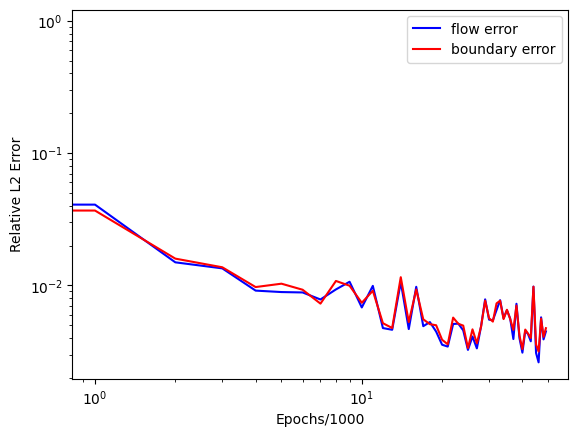

In [ ]:
plt.clf()
plt.loglog(flow_residuals,'b',label="flow error")
plt.loglog(bdy_residuals,'r',label = 'boundary error')
plt.legend()
plt.xlabel("Epochs/1000")
plt.ylabel("Relative L2 Error")

plt.savefig("10D-ff-pinn-error.png")
# plt.show()

# fig,axs = plt.subplots(nrows=1,ncols=2)
# axs[0].loglog(flow_residuals,'b')
# axs[0].loglog(bdy_residuals,'r')
# axs[0].set_title("Relative L2 error")
# axs[0].set_xlabel("Epochs/1000")
# axs[0]
# axs[1].loglog(training_losses)
#       # axs[1].loglog(,'r')
# axs[1].set_title("Loss")
# plt.show()

print(f'final flow residual error is {flow_residuals[-1]}')
print(f'final boundary residual error is {bdy_residuals[-1]}')
print(f'total final error is {jnp.add(flow_residuals[-1],bdy_residuals[-1])}')

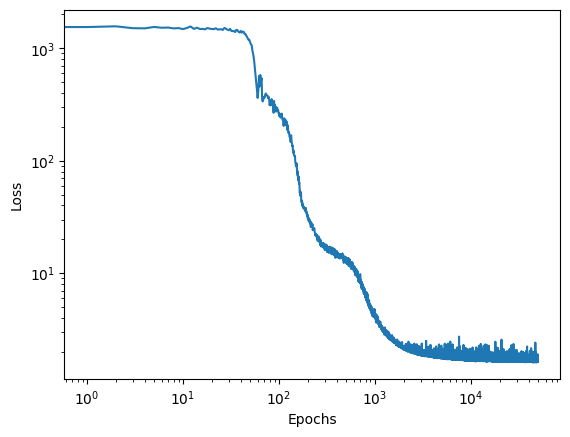

In [ ]:
plt.clf()
plt.loglog(training_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig("10d-ff-pinn-loss.png")

In [ ]:
# params